# NMEG tower data gapfilling and partitioning

A brief summary of methods and an analysis of the results of the gapfilling and partitioning procedures in place for NMEG tower data.

_Gregory Maurer, UNM, May 2015_

## Gapfilling

After raw meteorological and flux data have passed though our QA/QC process, there are numerous gaps where data has been removed (or was missing in the first place). For gaps in driving met data (Air temp, Incoming shortwave, Relative humidity, Precip) we fill as much as possible using nearby met station data. Sometimes these gaps are filled from adjacent NMEG flux towers, sometimes from met stations managed by other groups.

After met gapfilling, we send our data to the [MPI online tool](http://www.bgc-jena.mpg.de/~MDIwork/eddyproc) for further gapfilling. Net ecosystem CO2 exchange (NEE), latent (LE), and sensible heat (H) fluxes, air temperature (TA), incoming shortwave (SW\_IN), and VPD are all gapfilled using the methods described in [Reichstein et al 2005](http://dx.doi.org/10.1111/j.1365-2486.2005.001002.x) (appendix A). These are themselves adaptations of the _mean diurnal variation_ method of gapfilling found in [Falge et al 2001a](http://www.sciencedirect.com/science/article/pii/S0168192300002355) & [2001b](http://www.sciencedirect.com/science/article/pii/S0168192300002252). In general, this gapfilling method improves as more and higher quality driving met data is available (TA, SW\_IN, VPD data)

All variables filled using local met data or using the Reichstein 2005 method are given an '\_F' extension in our final data files (for public, Ameriflux, and internally used data files). Adjacent to each gapfilled columns there is a column with the same variable name plus the '\_FLAG' extension. In this column, '1' indicates the location of gapfilled values and observed values are indicated with a zero ( this column not present in daily files ).

## Partitioning

Two methodologies are widely used to partition eddy covariance CO2 flux (NEE) into ecosystem respiration (RECO) and gross primary productivity (GPP).

1. [Reichstein et al. 2005](http://dx.doi.org/10.1111/j.1365-2486.2005.001002.x)
    * Nighttime respiration data (assumed to equal RECO) is used to derive a temperature sensitivity function of RECO during the day and night.
    * Temperature sensitivity of RECO estimated every 5 days from a 15-day moving window using the Lloyd and Taylor 1994 T response function.
    * Continuous RECO is then modeled based on temperature (air or soil).
    * May be biased due to frequent nighttime suppression of turbulence and dominance of advective fluxes not measured by conventional EC systems.
    * Eddyproc output variables
        - RECO = continuously modeled respiration using nighttime flux data
        - NEE_F = Observed data where available, gaps filled using the Reichstein 2005 method (see above).
        - GPP_F = Reco - NEE_F
2. [Lasslop et al. 2010](http://dx.doi.org/10.1111/j.1365-2486.2009.02041.x)
    * GPP is modeled by fitting observed daytime flux data to a hyperbolic light-response function.
    * Daytime Reco is determined with a Lloyd and Taylor (1994) temperature response function from a combination of nighttime flux data (as in Reichstein approach) and daytime flux data.
    * Daytime Reco is then extrapolated into the nighttime using nighttime temperature.
    * VPD acts as a strong limiter of GPP.
    * Parameters are estimated every two days with a 4-day moving window when using the daytime data and a 12-day moving window when using the nighttime data.
    * Eddyproc output variables
        - RECO_HBLR = continuously modeled Reco using Lasslop method
        - GPP_HBLR = continuously modeld GPP using Lasslop method (light response curve)
        - NEE_HBLR = continuously modeled NEE equaling Reco_HBLR - GPP_HBLR
        
### Partitioning method by NMEG site

Whether we select Lasslop or Reichstein partitioned values for GPP and RECO in public data files (for Ameriflux) is site-dependent. Currently we use the Lassolop 2010 method for all sites except the Mixed Conifer (US-Vcm) and Ponderosa Pine (US-Vcp) sites (they use Reichstein).

## Ensuring carbon balance (ecb)

We add an additional set of steps to "ensure carbon balance". These are:

1. Calculate GPP as RECO - NEE  (this is redundant in the case of Reichstein)
2. Subtract nighttime positive GPP from RE (because this is not biologically possible). Nighttime is defined using slightly different radiation thresholds for each site.
3. Zero out RECO and NEE during any time periods in which RECO is negative.
4. Zero out any negative GPP periods and add this flux to RECO.

Overall this makes RECO and GPP more closely align with the original NEE values we have partitioned. In our internal data files the GPP and RECO columns with ensured C balance adjustments have variable names ending with '\_ecb'. The RECO and GPP columns in final, public data files (provided to Ameriflux) have ensured C balance, but the "ecb" extensions are removed. 

There is also an older set of adjustments that does not include steps 2 and 3, and columns with this adjustment have names ending in '\_oldecb' (internal files only).

## References

* Falge et al. 2001a: http://www.sciencedirect.com/science/article/pii/S0168192300002355
* Falge et al. 2001b: http://www.sciencedirect.com/science/article/pii/S0168192300002252
* Reichstein et al. 2005: http://dx.doi.org/10.1111/j.1365-2486.2005.001002.x
* Lasslop et al. 2010: http://dx.doi.org/10.1111/j.1365-2486.2009.02041.x

## Check results of gapfilling and partitioning

First set up environment and load 2009-2014 gapfilled Ameriflux data. 

In [1]:
import sys
#sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )
sys.path.append( '../NMEG_utils/py_modules/' )

%matplotlib inline
import load_nmeg as ld
import transform_nmeg as tr
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

sns.set_style( 'white' )

#af_path = '/home/greg/sftp/eddyflux/Ameriflux_files/provisional/'
af_path = 'C:\\Research_Flux_Towers\\Ameriflux_files\\'

start = 2009
end = 2014

site = 'US-Seg'

site_data = ld.get_multiyr_aflx( site, af_path, gapfilled=True, startyear=start, endyear=end)


Parsing C:\Research_Flux_Towers\Ameriflux_files\US-Seg_2009_gapfilled.txt
Parsing C:\Research_Flux_Towers\Ameriflux_files\US-Seg_2010_gapfilled.txt
Parsing C:\Research_Flux_Towers\Ameriflux_files\US-Seg_2011_gapfilled.txt
Parsing C:\Research_Flux_Towers\Ameriflux_files\US-Seg_2012_gapfilled.txt
Parsing C:\Research_Flux_Towers\Ameriflux_files\US-Seg_2013_gapfilled.txt
Parsing C:\Research_Flux_Towers\Ameriflux_files\US-Seg_2014_gapfilled.txt


### Reichstein partitioning and C balance

AttributeError: 'DataFrame' object has no attribute 'NEE_MR2005_ecb'

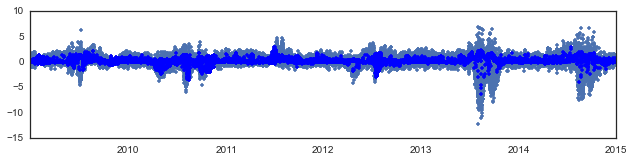

In [3]:
fig0 = plt.figure( figsize=( 10.5, 5 ), dpi=150, facecolor='w', edgecolor='k' )

# Reco subplot ( Reco is modeled, Fc_F is gapfilled )

# Locate filled Fc values
filledFC = site_data.FC_F_FLAG == 1

ax1 = fig0.add_subplot( 2, 1, 1 )
h1 = ax1.plot( site_data.index, site_data.FC_F, '.')
h1f = ax1.plot( site_data.index[ filledFC ], site_data.FC_F[ filledFC ], '.', color='Blue')
# This is identical to FC_F
h2 = ax1.plot( site_data.index, site_data.NEE_MR2005_ecb, '.',
              mfc='None', mec='#D3D3D3', mew=0.5 )
h3 = ax1.plot( site_data.index, site_data.RECO_MR2005, lw=0.7 )
h4 = ax1.plot( site_data.index, site_data.RECO_MR2005_ecb, ':', lw=0.7, color='Black' )
plt.ylabel('Fc (umol m-2 s-1)')
plt.legend( [ 'Fc (raw)', 'Fc gapfilled', 'NEE Reichstein_ecb', 
             'RE Reichstein', 'RE Reichstein_ecb' ], loc='lower right' )

# GPP subplot - calculated as Reco - Fc_F
ax2 = fig0.add_subplot( 2, 1, 2, sharex=ax1, sharey=ax1 )
h1 = ax2.plot( site_data.index, site_data.FC_F, '.')
h1f = ax2.plot( site_data.index[ filledFC ], site_data.FC_F[ filledFC ], '.', color='Blue')
# This is identical to FC_F unless Reco is negative
h2 = ax2.plot( site_data.index, site_data.NEE_MR2005_ecb, '.',
              mfc='None', mec='#D3D3D3', mew=0.5 )
h3 = ax2.plot( site_data.index, -site_data.GPP_F_MR2005, lw=0.7, color='Yellow' )
h4 = ax2.plot( site_data.index, -site_data.GPP_MR2005_ecb, ':', lw=0.7, color='Black' )
plt.ylabel('Fc (umol m-2 s-1)')
plt.legend( [ 'Fc (raw)', 'Fc gapfilled', 'NEE Reichstein_ecb',
             'GPP Reichstein', 'GPP Reichstein_ecb' ], loc='lower right' )
plt.show( fig0 )



### Cumulative fluxes (Reichstein)

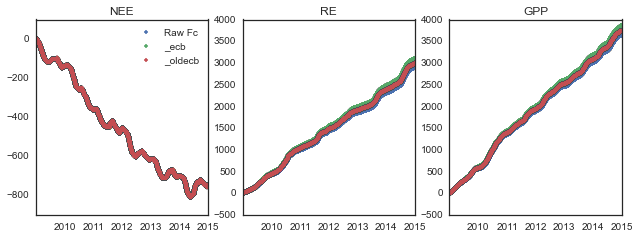

In [3]:
site_c_int = tr.sum_30min_c_flux( site_data[ ['FC_F', 'NEE_MR2005_ecb', 'NEE_MR2005_oldecb', 
                                            'RECO_MR2005', 'RECO_MR2005_ecb', 'RECO_MR2005_oldecb',
                                            'GPP_F_MR2005', 'GPP_MR2005_ecb', 'GPP_MR2005_oldecb' ] ])

fig1 = plt.figure( figsize=( 10.5, 3.5 ), dpi=150, facecolor='w', edgecolor='k' )
ax1 = fig1.add_subplot( 1, 3, 1, title='NEE' )
h1 = ax1.plot( site_data.index, site_c_int.FC_F_g_int.cumsum(), '.')
h2 = ax1.plot( site_data.index, site_c_int.NEE_MR2005_ecb_g_int.cumsum(), '.')
h3 = ax1.plot( site_data.index, site_c_int.NEE_MR2005_oldecb_g_int.cumsum(), '.')
plt.legend( [ 'Raw Fc','_ecb', '_oldecb' ], loc='upper right' )

ax2 = fig1.add_subplot( 1, 3, 2, title='RE' )
h1 = ax2.plot( site_data.index, site_c_int.RECO_MR2005_g_int.cumsum(), '.')
h2 = ax2.plot( site_data.index, site_c_int.RECO_MR2005_ecb_g_int.cumsum(), '.')
h3 = ax2.plot( site_data.index, site_c_int.RECO_MR2005_oldecb_g_int.cumsum(), '.')

ax3 = fig1.add_subplot( 1, 3, 3, title='GPP', sharey=ax2 )
h1 = ax3.plot( site_data.index, site_c_int.GPP_F_MR2005_g_int.cumsum(), '.')
h2 = ax3.plot( site_data.index, site_c_int.GPP_MR2005_ecb_g_int.cumsum(), '.')
h3 = ax3.plot( site_data.index, site_c_int.GPP_MR2005_oldecb_g_int.cumsum(), '.')

plt.show( fig1 )


### Lasslop partitioning and C balance

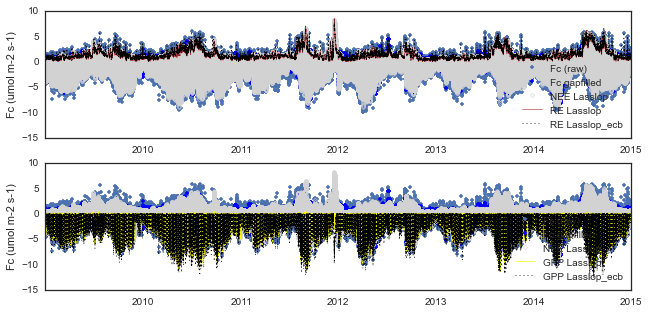

In [4]:
fig2 = plt.figure( figsize=( 10.5, 5 ), dpi=150, facecolor='w', edgecolor='k' )

# Reco subplot ( Reco is modeled, Fc_F is gapfilled )
ax1 = fig2.add_subplot( 2, 1, 1 )
h1 = ax1.plot( site_data.index, site_data.FC_F, '.')
h1f = ax1.plot( site_data.index[ filledFC ], site_data.FC_F[ filledFC ], '.', color='Blue')
# Currently NEE_GL2010 is not in the AF files
h2 = ax1.plot( site_data.index, site_data.RECO_GL2010-site_data.GPP_GL2010, '.',
              mfc='None', mec='#D3D3D3', mew=0.5 )
h3 = ax1.plot( site_data.index, site_data.RECO_GL2010, lw=0.7 )
h4 = ax1.plot( site_data.index, site_data.RECO_GL2010_ecb, ':', lw=0.7, color='Black' )
plt.ylabel('Fc (umol m-2 s-1)')
plt.legend( [ 'Fc (raw)', 'Fc gapfilled', 'NEE Lasslop', 
             'RE Lasslop', 'RE Lasslop_ecb' ], loc='lower right' )

# GPP subplot - calculated as Reco - Fc_F
ax2 = fig2.add_subplot( 2, 1, 2, sharex=ax1, sharey=ax1 )
h1 = ax2.plot( site_data.index, site_data.FC_F, '.')
h1f = ax2.plot( site_data.index[ filledFC ], site_data.FC_F[ filledFC ], '.', color='Blue')
h2 = ax2.plot( site_data.index, site_data.RECO_GL2010-site_data.GPP_GL2010, '.',
              mfc='None', mec='#D3D3D3', mew=0.5 )
h3 = ax2.plot( site_data.index, -site_data.GPP_GL2010, lw=0.7, color='Yellow' )
h4 = ax2.plot( site_data.index, -site_data.GPP_GL2010_ecb, ':', lw=0.7, color='Black' )
plt.ylabel('Fc (umol m-2 s-1)')
plt.legend( [ 'Fc (raw)','Fc gapfilled', 'NEE Lasslop', 
             'GPP Lasslop', 'GPP Lasslop_ecb' ], loc='lower right' )
plt.show( fig2 )


### Cumulative fluxes (Lasslop)

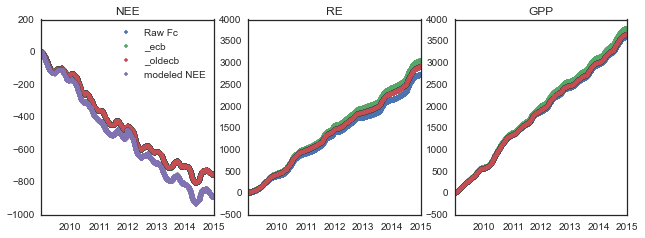

In [5]:
site_c_int = tr.sum_30min_c_flux( site_data[ ['FC_F', 'NEE_GL2010_ecb', 'NEE_GL2010_oldecb', 
                                            'RECO_GL2010', 'RECO_GL2010_ecb', 'RECO_GL2010_oldecb',
                                            'GPP_GL2010', 'GPP_GL2010_ecb', 'GPP_GL2010_oldecb' ] ])

fig1 = plt.figure( figsize=( 10.5, 3.5 ), dpi=150, facecolor='w', edgecolor='k' )
ax1 = fig1.add_subplot( 1, 3, 1, title='NEE' )
h1 = ax1.plot( site_data.index, site_c_int.FC_F_g_int.cumsum(), '.')
h2 = ax1.plot( site_data.index, site_c_int.NEE_GL2010_ecb_g_int.cumsum(), '.')
h3 = ax1.plot( site_data.index, site_c_int.NEE_GL2010_oldecb_g_int.cumsum(), '.')
# Not present in AF files, must be calculated
NEE_GL2010_g_int = site_c_int.RECO_GL2010_g_int - site_c_int.GPP_GL2010_g_int
h4 = ax1.plot( site_data.index, NEE_GL2010_g_int.cumsum(), '.')
plt.legend( [ 'Raw Fc','_ecb', '_oldecb', 'modeled NEE' ], loc='upper right' )

ax2 = fig1.add_subplot( 1, 3, 2, title='RE' )
h1 = ax2.plot( site_data.index, site_c_int.RECO_GL2010_g_int.cumsum(), '.')
h2 = ax2.plot( site_data.index, site_c_int.RECO_GL2010_ecb_g_int.cumsum(), '.')
h3 = ax2.plot( site_data.index, site_c_int.RECO_GL2010_oldecb_g_int.cumsum(), '.')

ax3 = fig1.add_subplot( 1, 3, 3, title='GPP', sharey=ax2 )
h1 = ax3.plot( site_data.index, site_c_int.GPP_GL2010_g_int.cumsum(), '.')
h2 = ax3.plot( site_data.index, site_c_int.GPP_GL2010_ecb_g_int.cumsum(), '.')
h3 = ax3.plot( site_data.index, site_c_int.GPP_GL2010_oldecb_g_int.cumsum(), '.')

plt.show( fig1 )

### Diagnostic figure

This defines a figure that compares Reichstein and Lasslop partitioning (RE or GPP) along with met variables and NEE. It is useful for diagnosing problems with the partitioning and ensure carbon balance steps we use for our fluxes.

In [6]:
def diagfig( dat, fluxtype ):
    
    # Set up variables depending on flux (RE/GPP)
    if fluxtype.lower()=='re':
        fluxvarGL = 'RECO_GL2010'
        fluxvarMR = 'RECO_MR2005'
        fluxvarMR2 = 'RECO_MR2005' # This doesn't change for respiration
        sign = 1
    elif fluxtype.lower()=='gpp':
        fluxvarGL = 'GPP_GL2010'
        fluxvarMR = 'GPP_F_MR2005'
        fluxvarMR2 = 'GPP_MR2005' # It does change for GPP
        sign = -1
    
    # Locate filled Fc values
    filledFC = dat.FC_F_flag == 1
    # Create figure canvas
    dfig = plt.figure( figsize=( 10.5, 6 ), dpi=150, facecolor='w', edgecolor='k' )
    
    # Subplot showing Lasslop partitioning
    ax1 = dfig.add_subplot( 4, 1, 1 )
    h1 = ax1.plot( dat.index, dat.FC_F, '.' )
    # Circle the gapfilled FC points
    h2 = ax1.plot( dat.index[ filledFC ], dat.FC_F[ filledFC ],
                  '.', mfc='None', mec='#40E0D0', mew=0.5 )
    # Plot the variable in question
    h3 = ax1.plot( dat.index, dat[ fluxvarGL ]*sign, lw=0.9 )
    h4 = ax1.plot( dat.index, dat[ fluxvarGL + '_ecb' ]*sign, ':', 
                  lw=0.9, color='Black', alpha=.6 )
    plt.ylabel('Fc (umol m-2 s-1)')
    plt.legend( [ 'Fc (raw)','Fc (filled)', fluxtype, 
                 fluxtype + '_ecb'], loc='lower right' )
    plt.setp( ax1.get_xticklabels(), visible=False)
    plt.title( 'Lasslop ' + fluxtype)
    
    # Subplot showing Reichstein partitioning
    ax2 = dfig.add_subplot( 4, 1, 2, sharex = ax1 )
    h1 = ax2.plot( dat.index, dat.FC_F, '.' )
    # Circle the gapfilled FC points
    h2 = ax2.plot( dat.index[ filledFC ], dat.FC_F[ filledFC ],
                  '.', mfc='None', mec='#40E0D0', mew=0.5 )
    # Plot the variable in question
    h3 = ax2.plot( dat.index, dat[ fluxvarMR ]*sign, lw=0.9 )
    h4 = ax2.plot( dat.index, dat[ fluxvarMR2 + '_ecb' ]*sign, ':', 
                  lw=0.9, color='Black', alpha=.6 )
    plt.ylabel('Fc (umol m-2 s-1)')
    plt.legend( [ 'Fc (raw)','Fc (filled)', fluxtype, 
                 fluxtype + '_ecb'], loc='lower right' )
    plt.setp( ax2.get_xticklabels(), visible=False)
    plt.title( 'Reichstein ' + fluxtype)
    
    # Locate filled Tair values
    filledTA = dat.TA_f_flag == 1
    
    # Subplot showing Tair and Precip
    ax3 = dfig.add_subplot( 4, 1, 3 , sharex = ax1 )
    h5 = ax3.plot( dat.index, dat.TA_f )
    h6 = ax3.plot( dat.index[ filledTA ], dat.TA_f[ filledTA ], 
                  '.', mfc='None', mec='#40E0D0', mew=0.5 )
    ax4 = ax3.twinx()
    h7 = ax4.plot( dat.index, dat.PRECIP_f, alpha=.5, color='Black' ) 
    ax3.set_ylabel('Tair')
    ax4.set_ylabel('Precip')
    plt.setp( ax3.get_xticklabels(), visible=False)
    
    #Locate filled Rg values
    filledRG = dat.Rg_f_flag == 1
    
    # Subplot showing Rg and VPD
    ax5 = dfig.add_subplot( 4, 1, 4, sharex=ax1 )
    h8 = ax5.plot( dat.index, dat.Rg_f )
    h9 = ax5.plot( dat.index[ filledRG ], dat.Rg_f[ filledRG ], 
                  '.', mfc='None', mec='#40E0D0', mew=0.5 )
    ax6 = ax5.twinx()
    h10 = ax6.plot( dat.index, dat.VPD_f, alpha=.5, color='Black' ) 
    ax5.set_ylabel('SW_in')
    ax6.set_ylabel('VPD')
    
    return dfig
    

### Make diagnostic plots for all years/individual years

Use the figure defined above to examine Reichstein and Lasslop partitioning for all years at a site, and for individual years. These plots are output as png files to ./figures/partfigs/

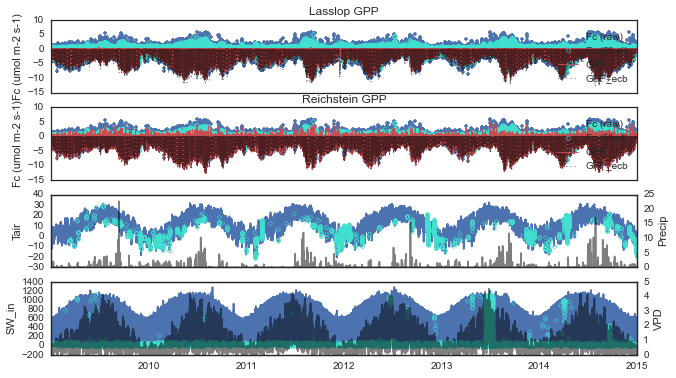

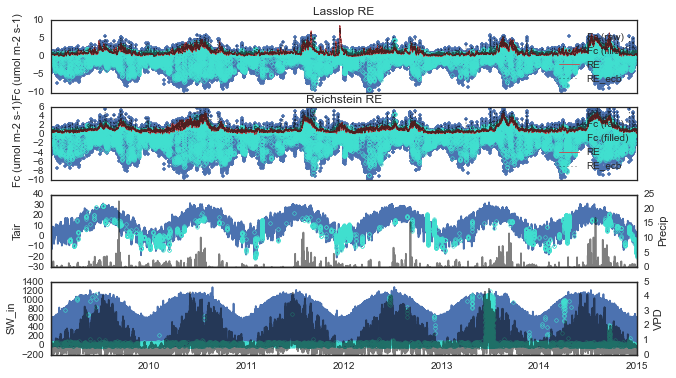

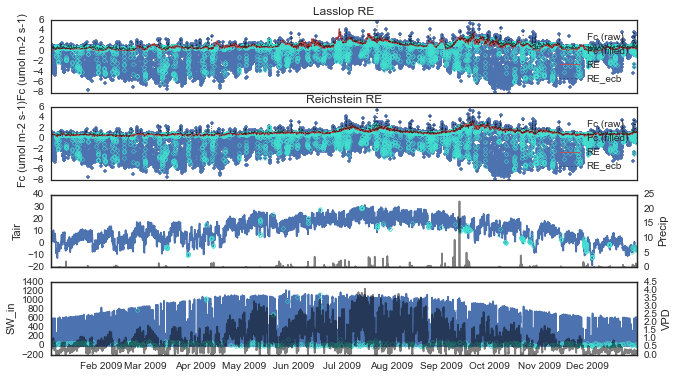

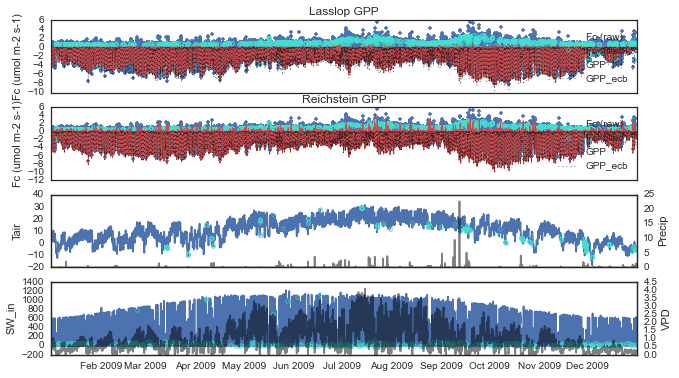

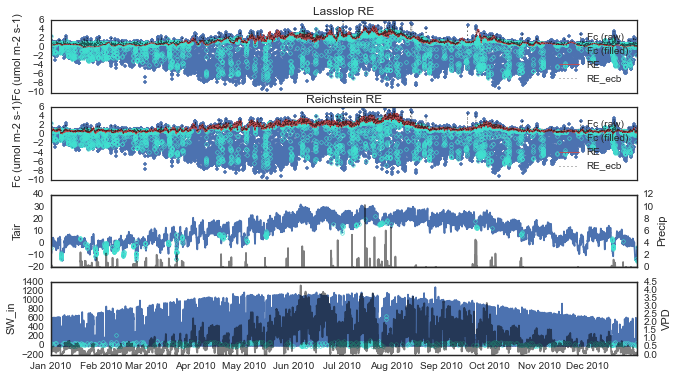

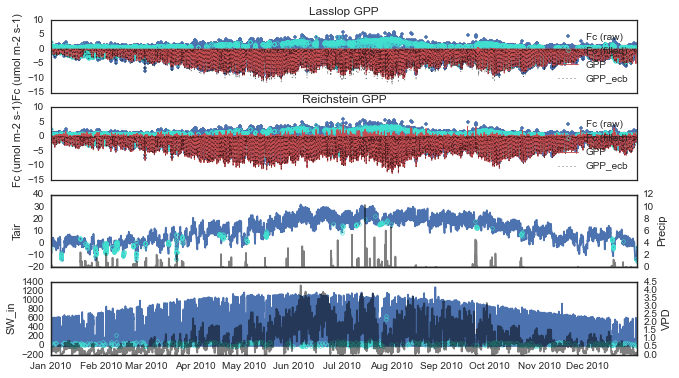

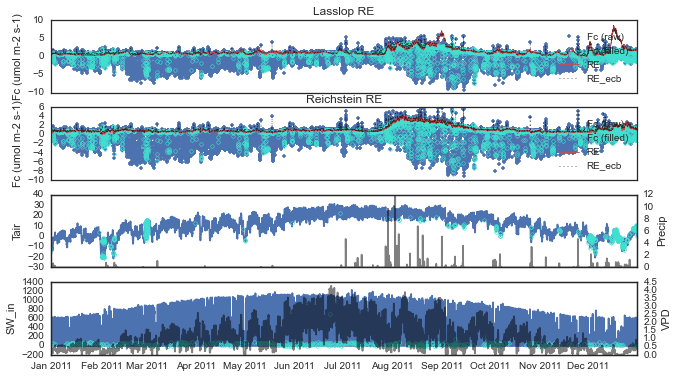

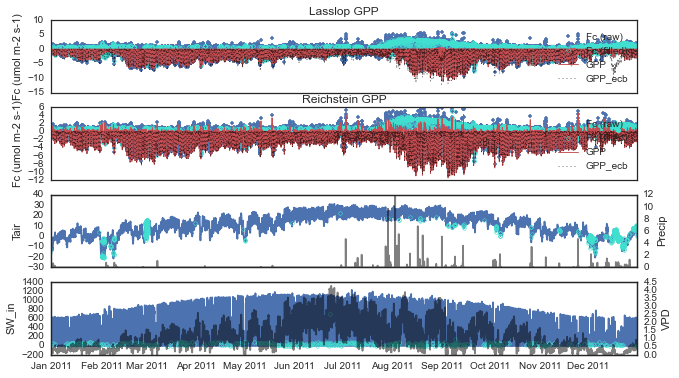

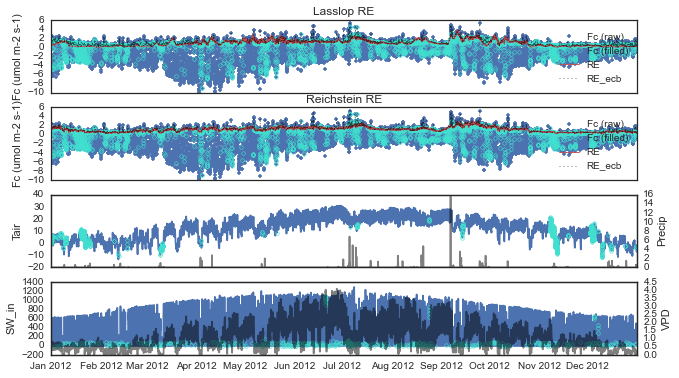

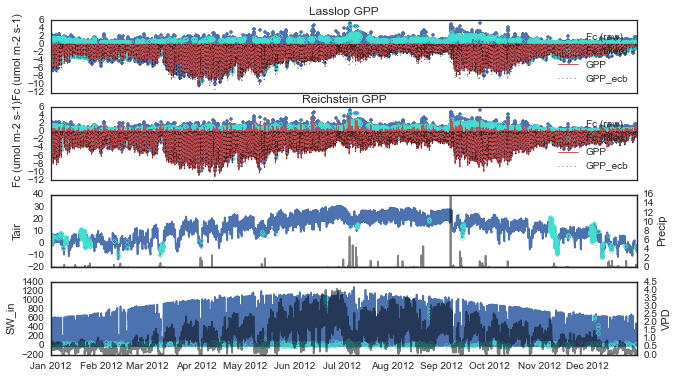

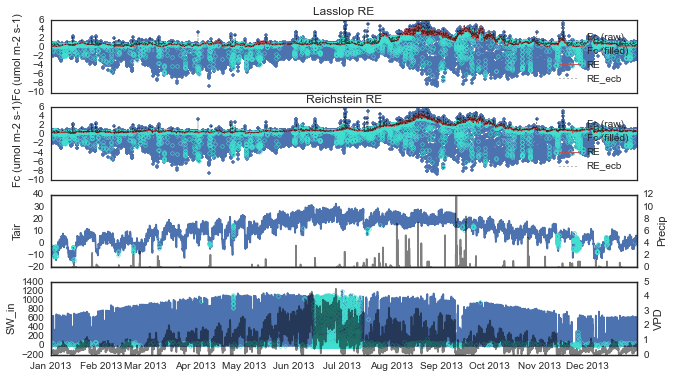

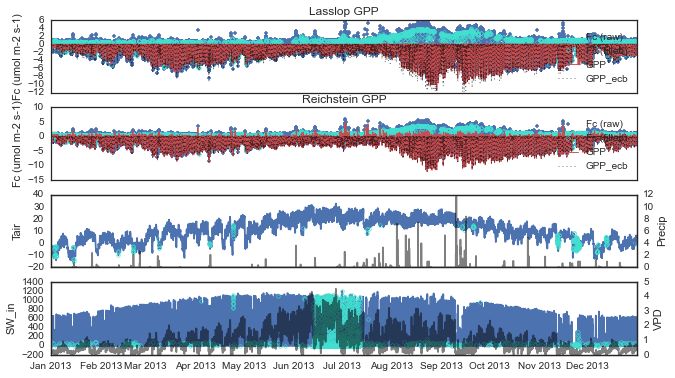

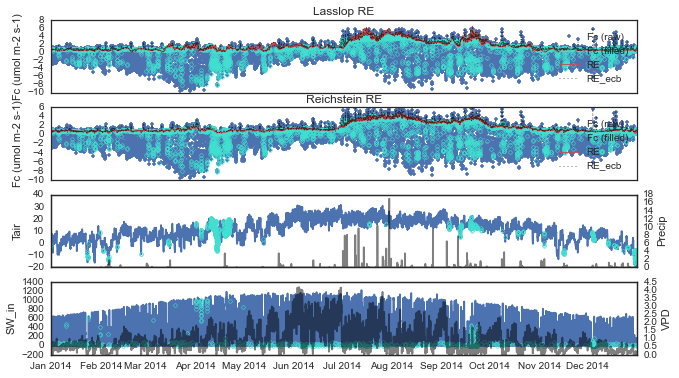

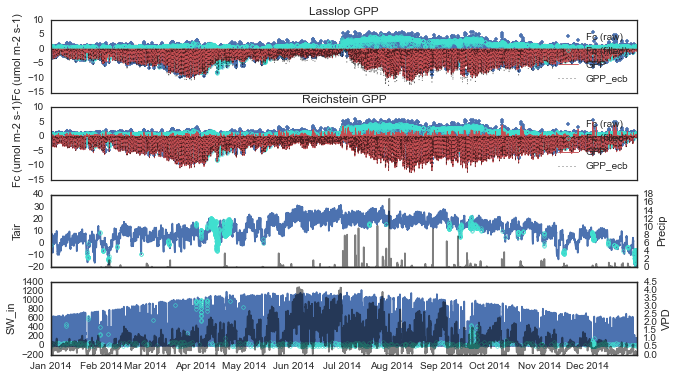

In [7]:
# First plot multiyear figures

gppfig = diagfig( site_data, 'GPP' )
figname = 'figures/partfigs/' + site + '_' + 'GPP' + '_' + 'ALLYEARS' + '_new.png'
gppfig.savefig( figname, dpi=gppfig.dpi )

refig = diagfig( site_data, 'RE' )
figname = 'figures/partfigs/' + site + '_' + 'RE' + '_' + 'ALLYEARS' + '_new.png'
refig.savefig( figname, dpi=refig.dpi )

# Then plot a figure showing each individual year
for i in range(start,end+1):
    data = site_data[ site_data.index.year == i ]
    
    var = 'RE'
    fig = diagfig( data, var )
    figname = 'figures/partfigs/' + site + '_' + var + '_' + str(i) + '_new.png'
    fig.savefig( figname, dpi=fig.dpi )
    
    var = 'GPP'
    fig = diagfig( data, var )
    figname = 'figures/partfigs/' + site + '_' + var + '_' + str(i) + '_new.png'
    fig.savefig( figname, dpi=fig.dpi )
    
plt.show()